# 10. Visualization of Local Explanations

This notebook, part of the analysis phase of the project, is devoted to visualizing the hierarchical local explanations generated by IDG.

In [ ]:
# Necessary imports
import polars as pl
import sys
import numpy as np

import torch

import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from tqdm.auto import tqdm as tqdma

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
)

# Get the absolute path of the project's root directory
ROOT_DIR = Path.resolve(Path.cwd() / "../")

# Add root directory to sys.path
sys.path.append(str(ROOT_DIR))

from src.utils.set_seed import set_seed
from src.utils.expl_utils import (
    predict_sample,
    get_attributions_by_level,
    plot_local_explanation,
)

# Set the seed for reproducibility
rng = set_seed()



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2025-05-14 09:02:54.187726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 09:02:54.250718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 09:02:54.263981: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 09:02:54.269611: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has al

In [ ]:
# Directory management
DATA_DIR = ROOT_DIR / ".data"
SPLITTED_DATA_DIR = DATA_DIR / "splitted"

MODELS_DIR = ROOT_DIR / "models"

OUTPUT_DIR = ROOT_DIR / "output"
IG_DIR = OUTPUT_DIR / "integrated_gradients"
TREES_DIR = OUTPUT_DIR / "constituency_trees"
IDG_DIR = OUTPUT_DIR / "integrated_directional_gradients"
SHAP_DIR = OUTPUT_DIR / "shap"

EVALUATION_DIR = OUTPUT_DIR / "evaluation"


In [3]:
# Load the dataset
df_test_trees = pl.read_parquet(TREES_DIR / "test_2_classes_with_trees.parquet")


In [4]:
# Load the fine-tuned model and tokenizer
model_clf = AutoModelForSequenceClassification.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)

tokenizer = AutoTokenizer.from_pretrained(
    MODELS_DIR / "bert-base-uncased_2_classes",
)


In [5]:
# Label encoding
label2id = {"normal": 0, "hatespeech": 1}
id2label = {id_: label for label, id_ in label2id.items()}
target_labels = list(label2id.keys())


***

In [6]:
guids = df_test_trees["post_id"].to_list()


In [7]:
guids[0]


'13851720_gab'

In [ ]:
# guids = ["1178101883602272256_twitter"]
# guids = ["21209681_gab"]
# # guids = ["1179055004553900032_twitter"]

mpl.use("Agg")
plt.ioff()

for guid in tqdma(guids):
    try:
        # Load the tree
        dot_tree = nx.nx_agraph.read_dot(
            IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.dot",
        )
    except FileNotFoundError:
        print(f"File not found for guid: {guid}")
        continue

    tokens = df_test_trees.filter(pl.col("post_id") == guid)[
        "tokens"
    ].to_numpy()[0]

    try:
        attributions_by_level = get_attributions_by_level(
            dot_tree,
            tokens,
            directionless=False,
            include_whole_sentence=True
        )
    except Exception as _:
        print(f"Exception when trying to get attributions for guid = {guid}")
        continue


    probs = predict_sample(
        model_clf,
        tokenizer,
        df_test_trees.filter(pl.col("post_id") == guid)["tokens"].to_list()[0],
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    )

    predicted_class = np.argmax(probs)

    true_class = df_test_trees.filter(pl.col("post_id") == guid)["label"].to_list()[0]

    # print(f"True class: {id2label[true_class]}")
    # print(f"Predicted class: {id2label[predicted_class]}")


    fig, ax = plot_local_explanation(
        attributions_by_level,
        tokens,
        true_class=true_class,
        predicted_class=predicted_class,
        fontsize=12,
        max_word_length=1024,  # Truncate long phrases
        show_scores=True,  # Show scores
        score_precision=3,  # Show 3 decimal places
        color_range=(-0.65, +0.65),  # Adjust color rangeç
        class_labels=target_labels,
    )

    try:
        fig.savefig(
            IDG_DIR / f"balanced/{guid}_idg_expl_image_balanced.png",
            bbox_inches="tight",
            dpi=300,
        )
    except Exception as _:
        print(f"Exception when trying to save file for guid = {guid}")
        continue

    plt.close(fig)



  0%|          | 0/1376 [00:00<?, ?it/s]

{1: {'[0]': 0.05118726, '[1]': 0.08183462, '[10]': 0.03099529, '[11]': 0.13099502, '[12]': 0.03458658, '[13]': 0.02040025, '[14]': -0.02186442, '[15]': 0.02079471, '[16]': 0.02028138, '[17]': 0.06538463, '[18]': 0.0427758, '[19]': 0.07721162, '[2]': 0.03543087, '[20]': 0.02383834, '[21]': 0.07207634, '[22]': 0.11326025, '[3]': 0.02570681, '[4]': 0.0240061, '[5]': 0.02070107, '[6]': 0.01709545, '[7]': 0.02035122, '[8]': 0.01793644, '[9]': 0.02237727}, 2: {'[0, 1]': 0.13323967, '[2]': 0.03543087, '[15]': 0.02079471, '[16]': 0.02028138, '[17]': 0.06538463, '[18, 19, 20, 21, 22]': 0.32939237, '[3]': 0.02570681, '[4]': 0.0240061, '[5]': 0.02070107, '[6, 7]': 0.03751436, '[8]': 0.01793644, '[9, 10, 11, 12]': 0.22001235, '[13]': 0.02040025, '[14]': -0.02186442}, 3: {'[0, 1]': 0.13323967, '[2]': 0.03543087, '[16]': 0.02028138, '[17, 18, 19, 20, 21, 22]': 0.39501429, '[3]': 0.02570681, '[4]': 0.0240061, '[5]': 0.02070107, '[6, 7]': 0.03751436, '[8, 9, 10, 11, 12]': 0.23894161, '[13]': 0.0204002

Predicted label: hatespeech
Predicted probability: 0.9716
True label: hatespeech


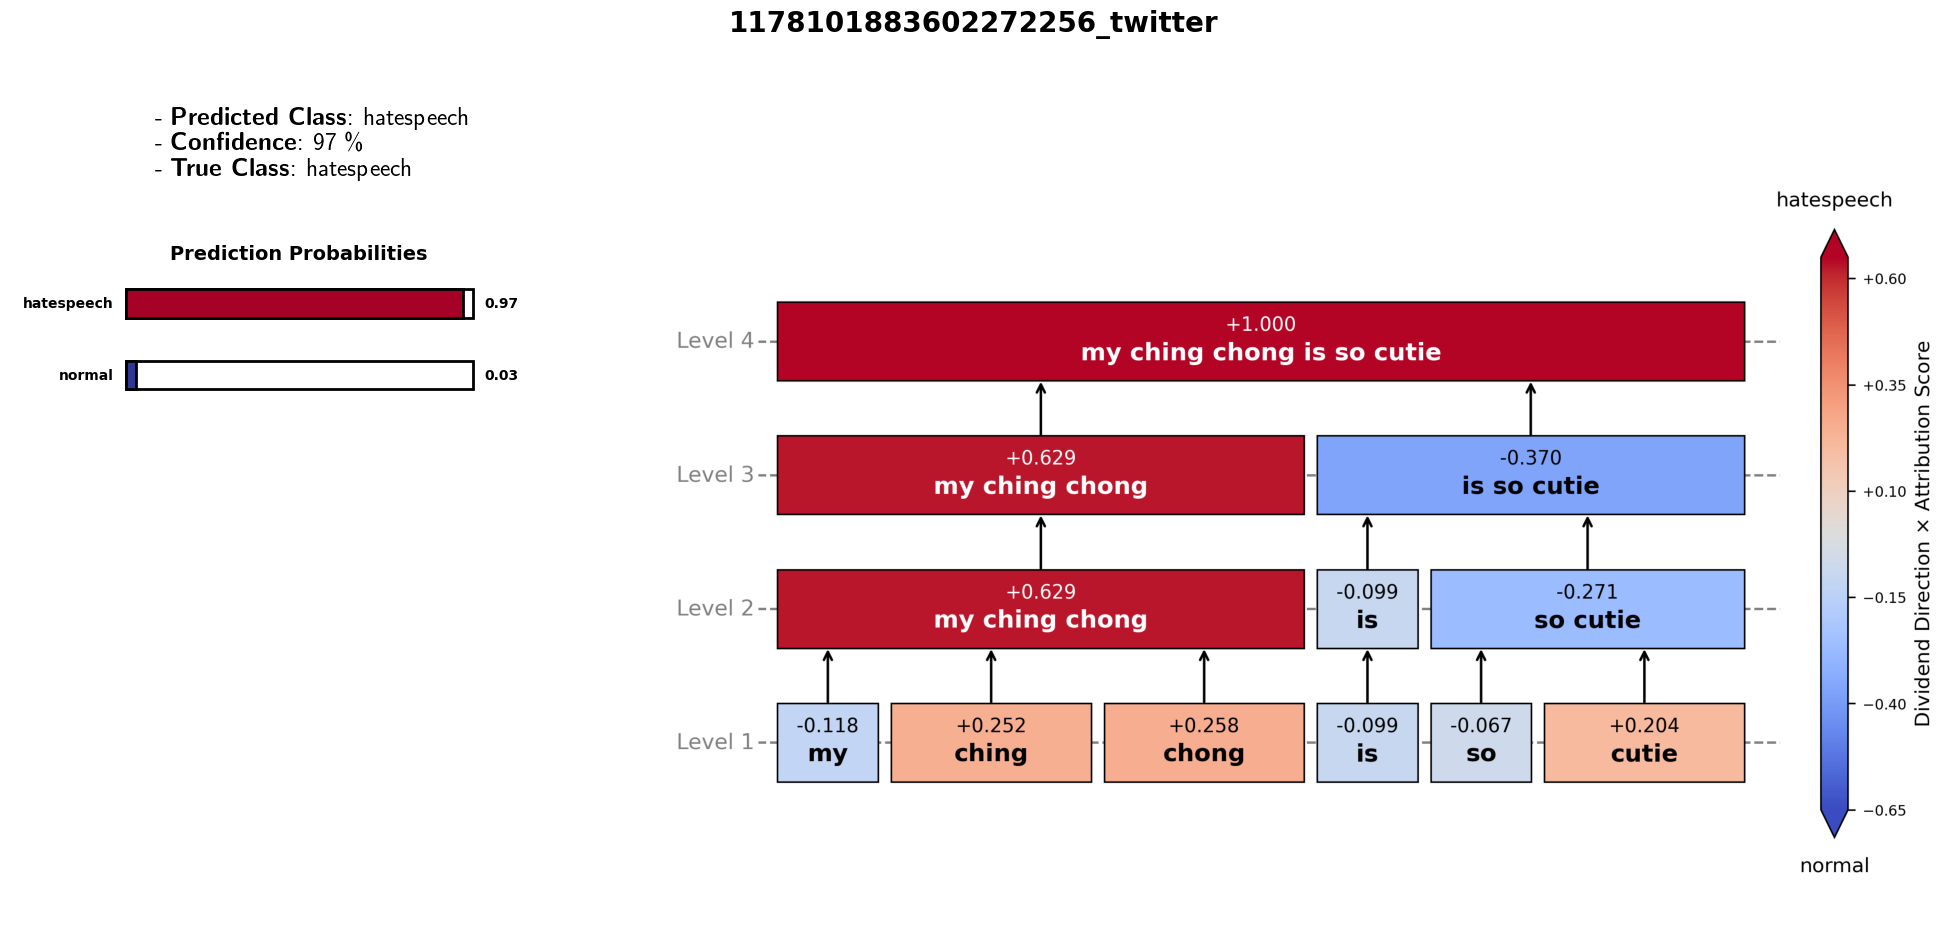

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.gridspec as gridspec

from src.analysis_utils import encode

%matplotlib inline
plt.ion()

def visualize_classification_report(
    df: pl.DataFrame,
    model_clf: object,
    tokenizer: object,
    device: torch.DeviceObjType,
    guid: str,
    id2label: dict,
    idg_dir: Path,
) -> None:
    # Compute prediction probabilities
    post = df.filter(pl.col("post_id") == guid)
    true_label = post["label"].to_list()[0]
    inputs = encode(post["tokens"].to_list()[0], tokenizer)
    model_clf.to(device)
    model_clf.eval()
    with torch.no_grad():
        logits = model_clf(
            inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
        ).logits

    probabilities = torch.softmax(logits, dim=1).cpu().numpy()[0]
    predicted_class = probabilities.argmax()
    predicted_label = id2label[predicted_class]
    predicted_prob = probabilities[predicted_class]
    print(f"Predicted label: {predicted_label}")
    print(f"Predicted probability: {predicted_prob:.4f}")
    print(f"True label: {id2label[post['label'].to_list()[0]]}")

    fig = plt.figure(figsize=(20, 10))

    gs = gridspec.GridSpec(3, 2, width_ratios=[.45, 1.], height_ratios=[0.25, 0.25, 1.], figure=fig)
    gs.update(wspace=.5, hspace=.05)

    ax_text = plt.subplot(gs[0, 0])
    ax_clas = plt.subplot(gs[1, 0])
    ax_tree = plt.subplot(gs[:, 1])

    # Probability bar plot
    clas_bar_width = 0.6
    clas_bar_height = 0.4
    clas_x_offset = (1 - clas_bar_width) / 2
    clas_y_pos = np.arange(len(id2label))

    cnorm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
    if predicted_label == "normal":
        cmapper = mpl.cm.ScalarMappable(norm=cnorm, cmap="RdYlBu_r")
    else:
        cmapper = mpl.cm.ScalarMappable(norm=cnorm, cmap="RdYlBu")

    bar_colors = [cmapper.to_rgba(1), cmapper.to_rgba(-1)]
    bar_colors = bar_colors[::-1] if predicted_label == "normal" else bar_colors


    for i, (prob, color) in enumerate(zip(probabilities, bar_colors)):
        # Draw full bar outline (white fill)
        ax_clas.add_patch(
            patches.Rectangle(
                (clas_x_offset, i - clas_bar_height / 2),
                clas_bar_width,
                clas_bar_height,
                edgecolor="black",
                facecolor="white",
                lw=2.0,
            ),
        )

        # Draw filled portion according to probability
        ax_clas.add_patch(
            patches.Rectangle(
                (clas_x_offset, i - clas_bar_height / 2),
                clas_bar_width * prob,
                clas_bar_height,
                edgecolor="black",
                facecolor=color,
                lw=2.0,
            ),
        )

        # Add text labels for probability inside bars
        ax_clas.text(
            clas_x_offset + clas_bar_width + 0.02,
            i,
            f"{prob:.2f}",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black",
        )
        # Add text labels for probability inside bars
        ax_clas.text(
            clas_x_offset - 0.02,
            i,  # Y position (center of bar)
            f"{list(id2label.values())[i]}",
            ha="right",
            va="center",
            fontsize=10,
            fontweight="bold",
            color="black",
        )


    ax_clas.yaxis.set_ticks_position("right")
    ax_clas.set_yticks([])
    ax_clas.set_xticks([])
    ax_clas.set_xlim(0, 1)
    ax_clas.set_ylim(-0.5, len(id2label) - 0.5)
    ax_clas.set_title("Prediction Probabilities", fontsize=14, fontweight="bold")
    ax_clas.spines["top"].set_visible(False)
    ax_clas.spines["right"].set_visible(False)
    ax_clas.spines["bottom"].set_visible(False)
    ax_clas.spines["left"].set_visible(False)


    # Text report plot
    for key in ax_text.spines:
        ax_text.spines[key].set_visible(False)

    ax_text.set_xticks([])
    ax_text.set_yticks([])

    report_text = rf"""
    - \textbf{{Predicted Class}}: {predicted_label}
    - \textbf{{Confidence}}: {predicted_prob*100:.0f} \%
    - \textbf{{True Class}}: {id2label[true_label]}
    """
    ax_text.text(0.25, .6, report_text,
                    ha="left",
                    va="center",
                    fontsize=18,
                    fontweight="normal",
                    usetex=True,
    )

    gs.tight_layout(fig)

    fig.suptitle(f"{guid}",
                 fontsize=20,
                 fontweight="bold",
                 y=1.05,
    )

    tree_file = idg_dir / f"balanced/{guid}_idg_expl_image_balanced.png"
    tree_img = plt.imread(tree_file)
    ax_tree.imshow(tree_img, origin="upper")
    ax_tree.axis("off")


guid = "1178101883602272256_twitter"

visualize_classification_report(
    df_test_trees,
    model_clf,
    tokenizer,
    torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    guid,
    id2label,
    IDG_DIR,
    OUTPUT_DIR,
)

plt.show()
